In [1]:
import numpy as np
import ROOT
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


In [2]:
# read in file
import os
file_name = f"{os.environ.get('HEP')}/data/ES_gvkm/ES_gvkm_clean_0127.root"
# file_name = f"{os.environ.get('HEP')}/data/marley_gvkm_clean_0114.root"
file = ROOT.TFile(file_name)
tree=file.PointResTree.tr

In [54]:
# loop through file
# define linear coefficients for energy reconstruction
def charge_to_energy_clean(charge):
    m = 259.218
    b = 901.312
    return (charge - b)/m
cosAngle_list = []
sample_size_per_bin = []
nbin_en = 7
e_max = 70
nbin_cosangle = 20
pdf = np.zeros([nbin_en, nbin_cosangle])
for e in tqdm(tree, total=tree.GetEntries()):
    if e.NTrks==0: continue
    en = charge_to_energy_clean(e.charge_corrected)
    if en > e_max: continue
    cosAngle = e.truth_nu_dir.Dot(e.reco_e_dir)
    en_binidx = int(en//(e_max/nbin_en)) if en > 0 else 0
    cosangle_binidx = int((cosAngle+1)//(2/nbin_cosangle))
    pdf[en_binidx, cosangle_binidx]+=1


100%|████████████████████████████████████████████████████████████████████████| 974000/974000 [00:12<00:00, 79568.24it/s]


In [55]:
# normalize pdf for each energy bin
from scipy.ndimage import gaussian_filter1d
pdf = np.where(pdf==0, 1, pdf)
pdf = np.sqrt(pdf)
for i in range(len(pdf)):
    pdf[i] = gaussian_filter1d(pdf[i], 1, order=0, mode='nearest')
    # energy_slice = pdf[i]
    # pdf[i] = np.log(pdf[i])
    sample_size_per_bin.append(np.sum(pdf[i]))
    pdf[i] = pdf[i] / np.sum(pdf[i])
# np.savetxt('ES_gvkm_radiological.dat', pdf)


Text(0, 0.5, '$e^-$ energy (MeV)')

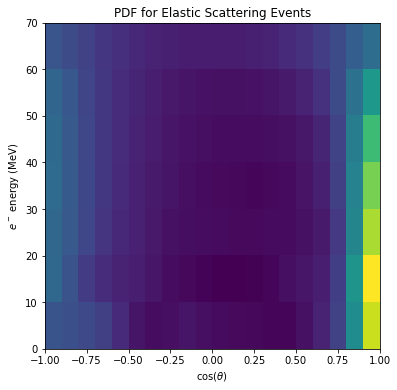

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pdf, extent=[-1,1,0,e_max], aspect='auto')
ax.set_title("PDF for Elastic Scattering Events")
ax.set_xlabel(r'$\cos(\theta)$')
ax.set_ylabel(r'$e^-$ energy (MeV)')

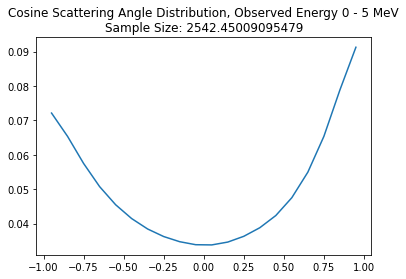

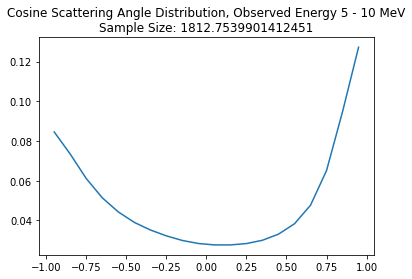

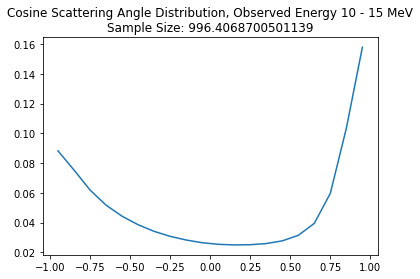

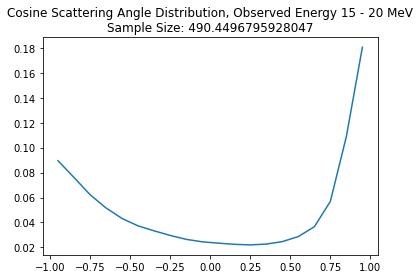

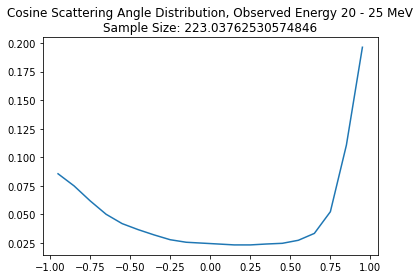

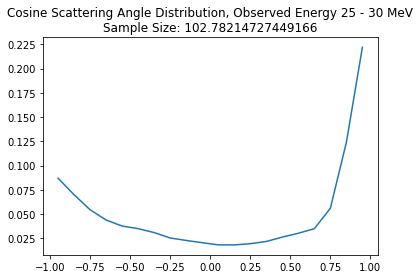

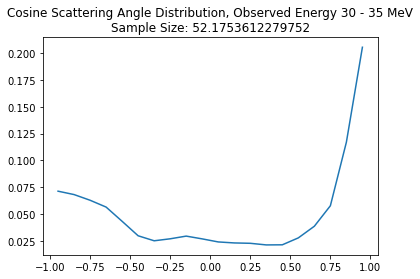

In [57]:
# energy slices
cosAngle_bins = np.linspace(-1, 1, num=20, endpoint=False) + 2/20/2
# print(cosAngle_bins)
for i, (pdf_slice, sample_size) in enumerate(zip(pdf, sample_size_per_bin)):
    plt.figure()
    plt.title(f"Cosine Scattering Angle Distribution, Observed Energy {i*5} - {(i+1)*5} MeV\n"\
            f"Sample Size: {sample_size}")
    plt.plot(cosAngle_bins, pdf_slice)

[]


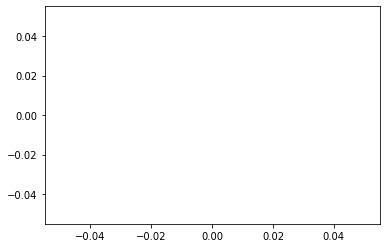

In [21]:
plt.plot(sample_size_per_bin)
charge_to_energy_clean(17750.482000000004)
print(sample_size_per_bin)

(20,)
(20,)


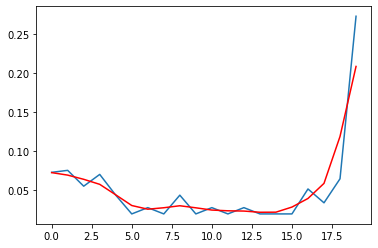

In [53]:
test_slice = pdf[6]
print(test_slice.shape)
plt.plot(test_slice)
test_slice = gaussian_filter1d(test_slice, 1, order=0, mode='nearest')
print(test_slice.shape)
plt.plot(test_slice, 'r')